In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

Посомтри на датасет титаника

In [6]:
id_surv = pd.read_csv('data/gender_submission.csv')

In [7]:
id_surv.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [9]:
train_data = pd.read_csv('data/train.csv')

In [26]:
pd.options.display.max_columns = 60
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
train_data.shape

(891, 12)

In [12]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [15]:
len(set(train_data['Ticket']))

681

In [18]:
len(set(train_data['Cabin']))

148

In [28]:
set(train_data['Embarked'])

{'C', 'Q', 'S', nan}

In [20]:
train_data.isna().sum(axis=0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Колонки `Cabin`, `Ticket` слишком разнообразны, почти уникальны. Избавимся от них и ещё от имени.

Много пропущеных значений. Т.к. мы предполагаем использование случайных лесов, то заменить пропуски имеет смысл на среднее.

Ещё нужно перекодировать категориальные признаки, например чтобы `sns.pairplot` достойно строился

In [66]:
def preprocess(df: pd.DataFrame()) -> pd.DataFrame():
    out = df.copy()
    out.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)
    
    cleanup_sex = {"Sex": {"male": 1, "female": 0}}
    out.replace(cleanup_sex, inplace=True)
    
    # порт в котором cltkftv lfvvb rjlbhjdrjq
    out = pd.get_dummies(out, columns=["Embarked"])
    
    out['Age'].fillna((out['Age'].mean()), inplace=True)
    return out

In [67]:
train_data_1 = preprocess(train_data)

Попробуем визуализировать

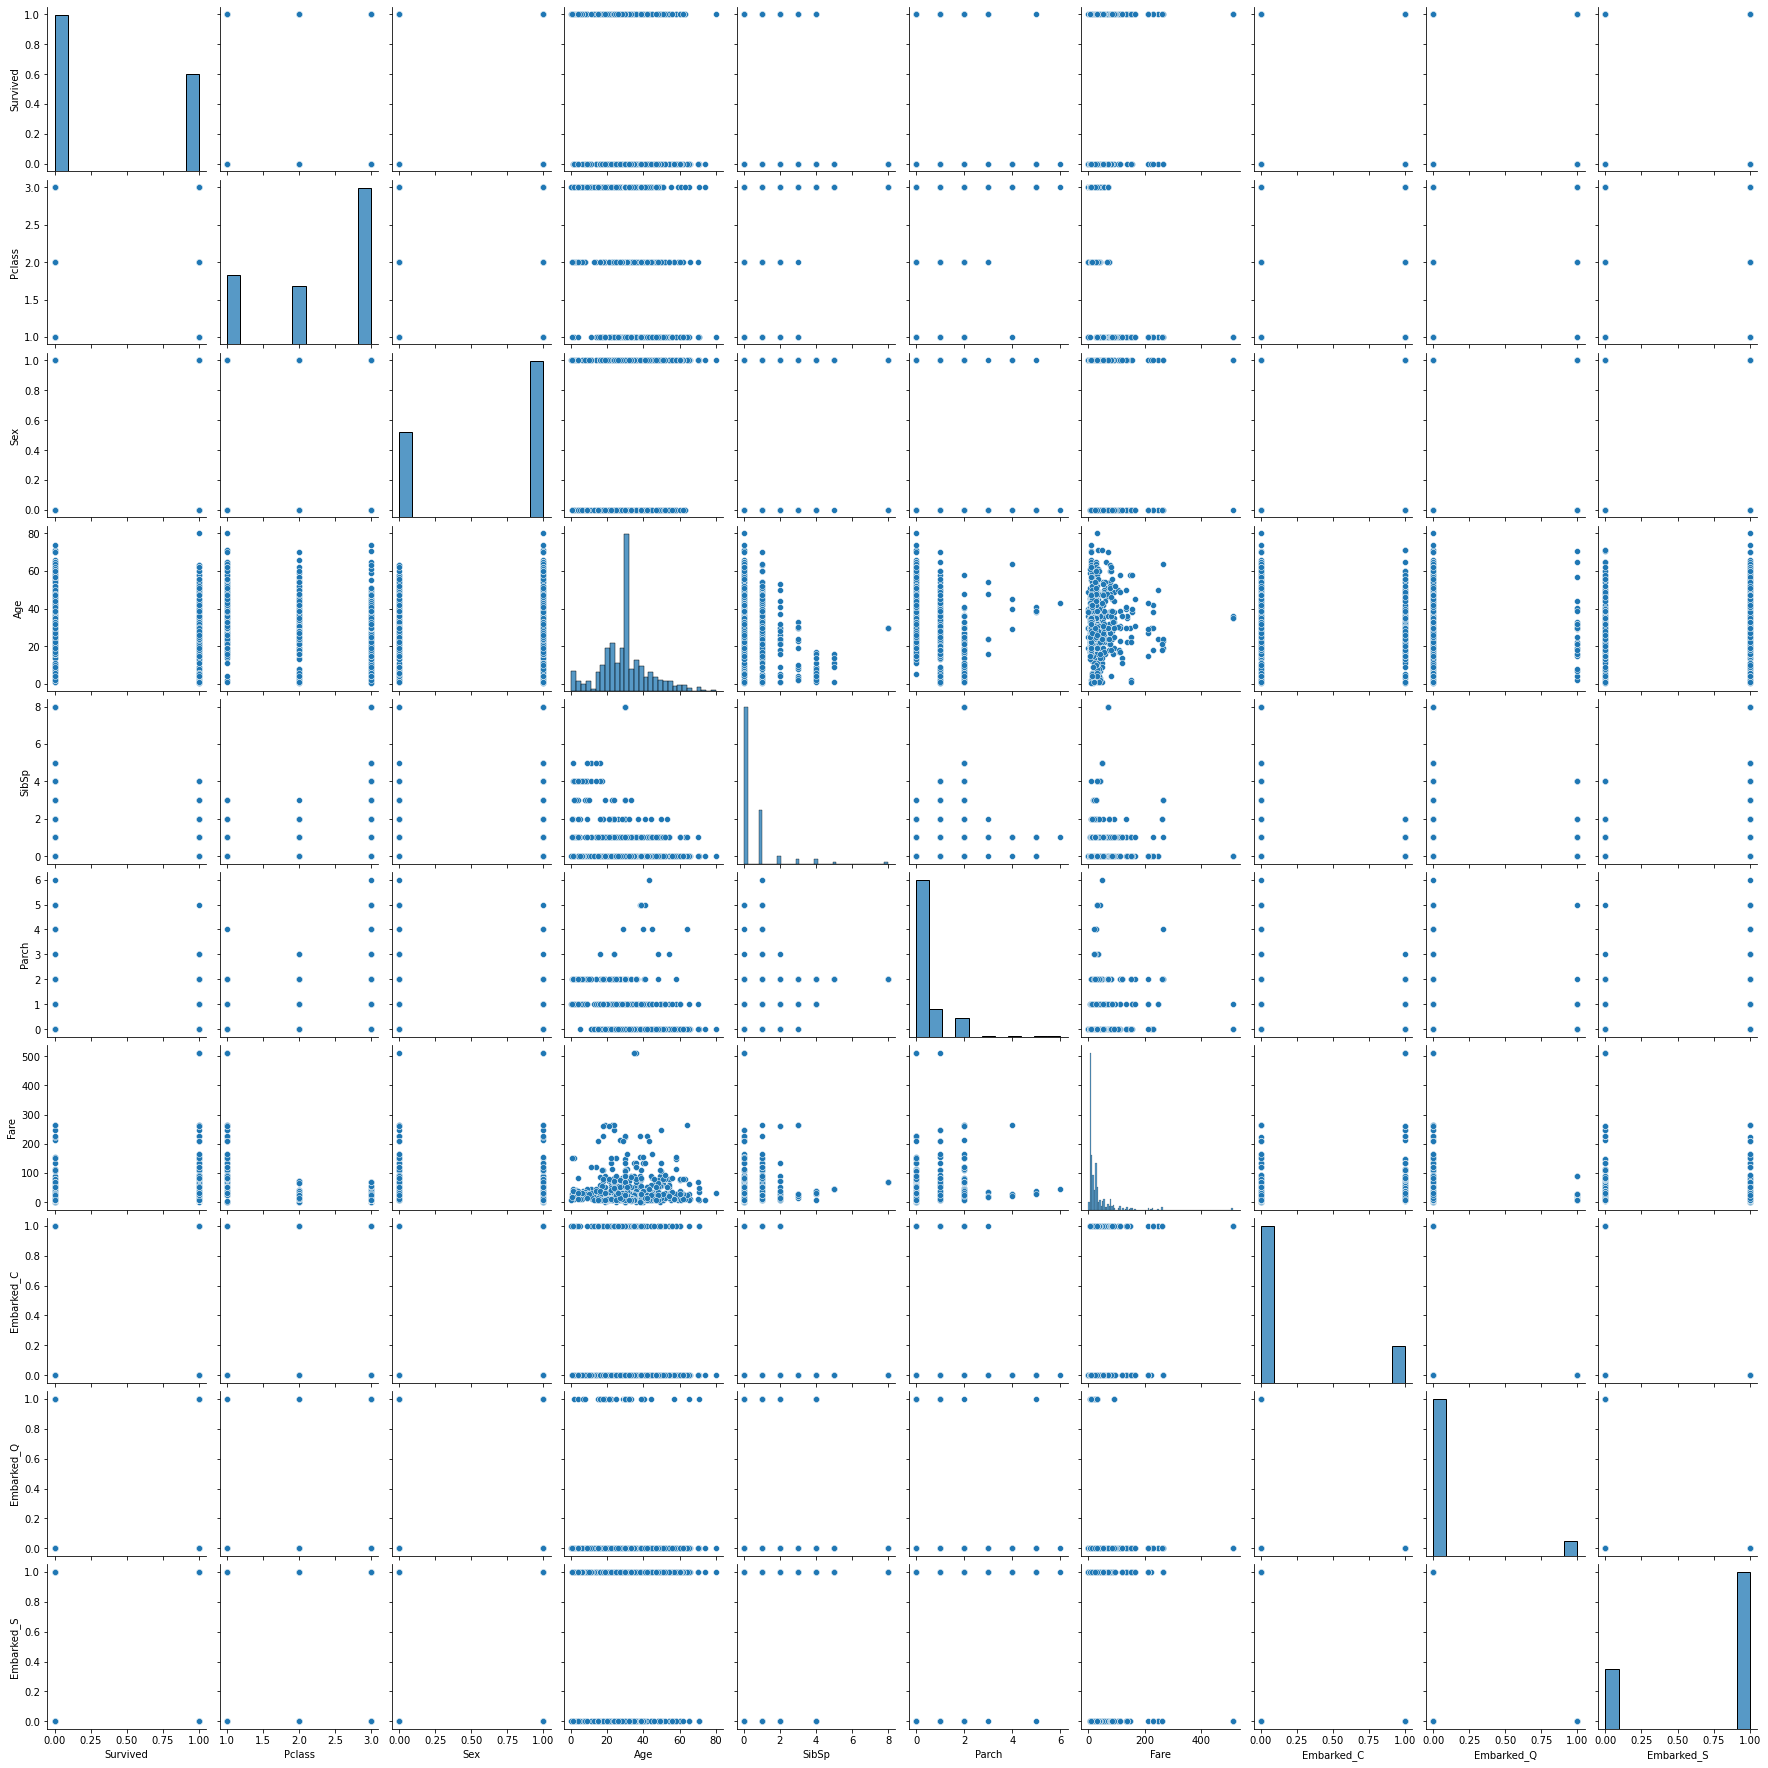

In [68]:
sns.pairplot(train_data_1)
plt.show()

Особо ничего не видно

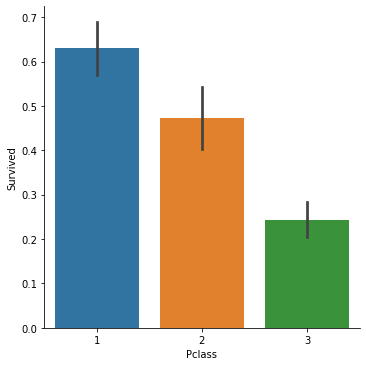

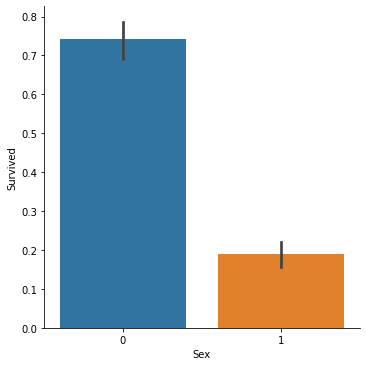

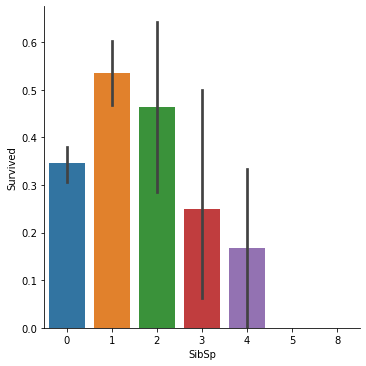

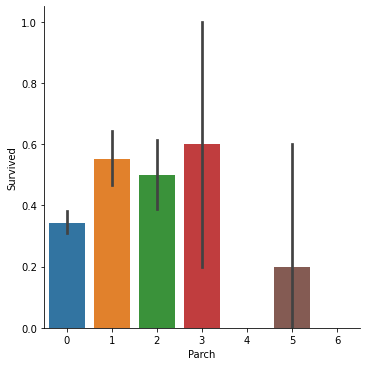

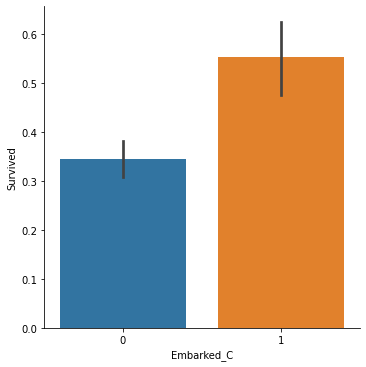

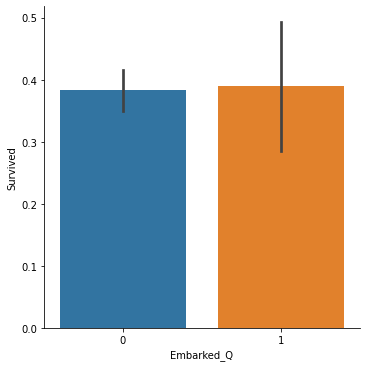

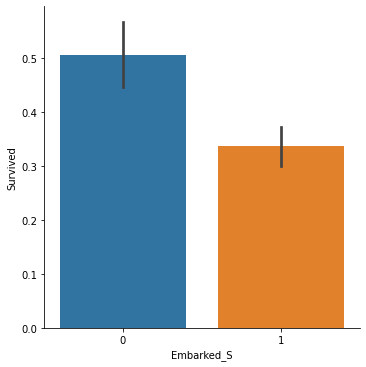

In [69]:
for c in train_data_1.drop(columns=['Survived', 'Age', 'Fare']).columns.values:
    sns.catplot(x=c, y='Survived', data=train_data_1, kind='bar').set_ylabels("Survived")
    plt.show()

Ну, тут видно, что пол и класс каюты наиболее важны. Отдельно глянем на возраст

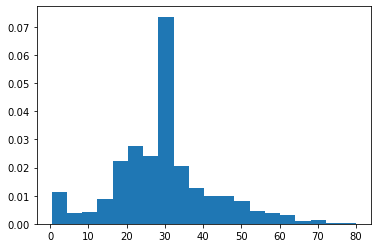

In [70]:
plt.hist(train_data_1['Age'], bins=20, density=True)
plt.show()

Выживали самые сильные и груднички

Ну всё, давайте fit, predict, оценим метрики и подомам

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [72]:
train_data_1.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0,3,1,22.0,1,0,7.2500,0,0,1
1,1,1,0,38.0,1,0,71.2833,1,0,0
2,1,3,0,26.0,0,0,7.9250,0,0,1
3,1,1,0,35.0,1,0,53.1000,0,0,1
4,0,3,1,35.0,0,0,8.0500,0,0,1


In [97]:
model = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42)

x = train_data_1.drop(columns=['Survived'])
y = train_data_1['Survived']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model.fit(x_train, y_train)
y_test_hat = model.predict(x_test)
y_train_hat = model.predict(x_train)

In [77]:
from sklearn.metrics import precision_recall_fscore_support

In [98]:
pr, rec, f1, _ = precision_recall_fscore_support(y_test, y_test_hat, average='binary')
print(f'Test\n\tprecision={pr:.2f}\n\trecall   ={rec:.2f}\n\tf1       ={f1:.2f}')
pr, rec, f1, _ = precision_recall_fscore_support(y_train, y_train_hat, average='binary')
print(f'Train\n\tprecision={pr:.2f}\n\trecall   ={rec:.2f}\n\tf1       ={f1:.2f}')

Test
	precision=0.84
	recall   =0.70
	f1       =0.76
Train
	precision=0.95
	recall   =0.75
	f1       =0.84


Вроде нормально

Посмотрим как `f1` зависит от глубины и числа деревьев

In [132]:
import plotly.graph_objects as go
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, make_scorer

In [135]:
scores = cross_validate(model, x, y, cv=3, scoring=make_scorer(f1_score), return_train_score=True)

In [138]:
scores['test_score']

array([0.61428571, 0.76821192, 0.7027027 , 0.71523179])

In [147]:
n_estims = np.linspace(5, 200, num=30, dtype=int)
depths = np.linspace(3, 45, num=30, dtype=int)
f1_test_scores = np.zeros((len(depths), len(n_estims)))
f1_train_scores = np.zeros((len(depths), len(n_estims)))
for _id_d, d in enumerate(depths):
    print(f'depth {_id_d+1} / {len(depths)}', end='\r')
    for _id_n, n_est in enumerate(n_estims):
        model = RandomForestClassifier(n_estimators=n_est, max_depth=d, random_state=42)
        scores = cross_validate(model, x, y, cv=5, scoring=make_scorer(f1_score), return_train_score=True)
        f1_test_scores[_id_d, _id_n] = scores['test_score'].mean()
        f1_train_scores[_id_d, _id_n] = scores['train_score'].mean()

In [157]:
fig = go.Figure(data=[go.Surface(z=f1_test_scores, x=depths, y=n_estims),
                      go.Surface(z=f1_train_scores, x=depths, y=n_estims)
                     ])
fig.update_layout(scene = dict(zaxis_title="f1 score",
                               xaxis_title="max depth",
                               yaxis_title="n estimators"),
                  title='F1 test depends on Random forest params', autosize=False,
                  width=500, height=500,
                 )
fig.show()

Какой вывод? Всё таки есть оптимальный набор параметров, котоырй характеризуется по большей части числом деревьев.
Макс глубину достаточно установаить $\geq 16$.

Да, сверху график F1 на обучении)

Получим тепреь лучшую модель, проверим на `test_data`

In [162]:
model_best = RandomForestClassifier(n_estimators=50, max_depth=20, random_state=42)

x = train_data_1.drop(columns=['Survived'])
y = train_data_1['Survived']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model.fit(x_train, y_train)
y_test_hat = model.predict(x_test)
y_train_hat = model.predict(x_train)

In [163]:
pr, rec, f1, _ = precision_recall_fscore_support(y_test, y_test_hat, average='binary')
print(f'Test\n\tprecision={pr:.2f}\n\trecall   ={rec:.2f}\n\tf1       ={f1:.2f}')
pr, rec, f1, _ = precision_recall_fscore_support(y_train, y_train_hat, average='binary')
print(f'Train\n\tprecision={pr:.2f}\n\trecall   ={rec:.2f}\n\tf1       ={f1:.2f}')

Test
	precision=0.79
	recall   =0.74
	f1       =0.76
Train
	precision=0.99
	recall   =0.96
	f1       =0.97


Кхм увеличился `f1` только на обучении...

А, ещё `precision` уменьшился, а `recall` увеличился.